In [1]:
import pymc3 as pm

/Users/hbi16859/anaconda/envs/python36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.4.1


Linear regression example:
Y∼N(μ,σ2)

μ=α+β1X1+β2X2

α∼N(0,100)

βi∼N(0,100)

σ∼|N(0,1)|

We can simulate some artificial data from this model using only NumPy’s random module, and then use PyMC3 to try to recover the corresponding parameters. We are intentionally generating the data to closely correspond the PyMC3 model structure.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

# Initialize random number generator
np.random.seed(123)

# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

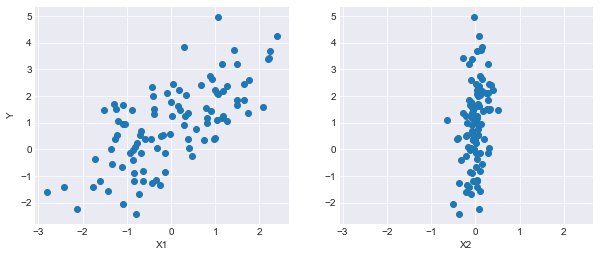

In [4]:
%matplotlib inline

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,4))
axes[0].scatter(X1, Y)
axes[1].scatter(X2, Y)
axes[0].set_ylabel('Y'); axes[0].set_xlabel('X1'); axes[1].set_xlabel('X2');

Model Specification
Specifying this model in PyMC3 is straightforward because the syntax is as close to the statistical notation. For the most part, each line of Python code corresponds to a line in the model notation above.

In [5]:
basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    sigma = pm.HalfNormal('sigma', sd=1)

    # Expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=Y)

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '7672' (I am process '51461')


Model fitting


Having completely specified our model, the next step is to obtain posterior estimates for the unknown variables in the model. Ideally, we could calculate the posterior estimates analytically, but for most non-trivial models, this is not feasible. We will consider two approaches, whose appropriateness depends on the structure of the model and the goals of the analysis: finding the maximum a posteriori (MAP) point using optimization methods, and computing summaries based on samples drawn from the posterior distribution using Markov Chain Monte Carlo (MCMC) sampling methods.


Maximum a posteriori methods

The maximum a posteriori (MAP) estimate for a model, is the mode of the posterior distribution and is generally found using numerical optimization methods. This is often fast and easy to do, but only gives a point estimate for the parameters and can be biased if the mode isn’t representative of the distribution. PyMC3 provides this functionality with the find_MAP function.

In [6]:
map_estimate = pm.find_MAP(model=basic_model)

logp = -149.58, ||grad|| = 12.242: 100%|██████████| 19/19 [00:00<00:00, 1144.17it/s] 


In [7]:
map_estimate

{'alpha': array(0.90660093),
 'beta': array([0.94848596, 2.60711845]),
 'sigma': array(0.96298858),
 'sigma_log__': array(-0.03771373)}

Most techniques for finding the MAP estimate also only find a local optimum (which is often good enough), but can fail badly for multimodal posteriors if the different modes are meaningfully different.

In summary, while PyMC3 provides the function find_MAP(), at this point mostly for historical reasons, this function is of little use in most scenarios. If you want a point estimate you should get it from the posterior. In the next section we will see how to get a posterior using sampling methods.

Sampling methods¶

Though finding the MAP is a fast and easy way of obtaining estimates of the unknown model parameters, it is limited because there is no associated estimate of uncertainty produced with the MAP estimates. Instead, a simulation-based approach such as Markov chain Monte Carlo (MCMC) can be used to obtain a Markov chain of values that, given the satisfaction of certain conditions, are indistinguishable from samples from the true posterior distribution.

PyMC3 has the standard sampling algorithms like adaptive Metropolis-Hastings and adaptive slice sampling, but PyMC3’s most capable step method is the No-U-Turn Sampler. NUTS is especially useful on models that have many continuous parameters, a situation where other MCMC algorithms work very slowly. 

PyMC3 automatically initializes NUTS to reasonable values based on the variance of the samples obtained during a tuning phase. A little bit of noise is added to ensure different, parallel, chains start from different points. Also, PyMC3 will automatically assign an appropriate sampler if we don’t supply it via the step keyword argument (see below for an example of how to explicitly assign step methods).

In [8]:
with basic_model:
    # draw 500 posterior samples
    trace = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_log__, beta, alpha]
100%|██████████| 1000/1000 [00:00<00:00, 1015.05it/s]


In [9]:
trace.alpha.shape

(2000,)

In [10]:
trace.alpha[-5]

0.9579880590502158

In [11]:
trace["alpha"][-5]

0.9579880590502158

If we wanted to use the slice sampling algorithm to sigma instead of NUTS (which was assigned automatically), we could have specified this as the step argument for sample.

In [12]:
with basic_model:

    # instantiate sampler
    step = pm.Slice()

    # draw 5000 posterior samples
    trace2 = pm.sample(5000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [sigma_log__]
>Slice: [beta]
>Slice: [alpha]
100%|██████████| 5500/5500 [00:07<00:00, 768.06it/s]


Posterior analysis

PyMC3 provides plotting and summarization functions for inspecting the sampling output. A simple posterior plot can be created using traceplot.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10e64c908>,
      dtype=object)

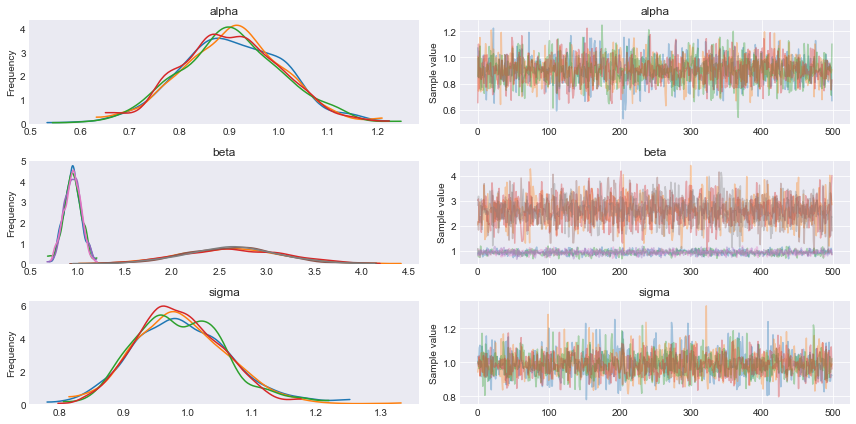

In [13]:
pm.traceplot(trace)

The left column consists of a smoothed histogram (using kernel density estimation) of the marginal posteriors of each stochastic random variable while the right column contains the samples of the Markov chain plotted in sequential order. The beta variable, being vector-valued, produces two histograms and two sample traces, corresponding to both predictor coefficients.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c23e94198>,
      dtype=object)

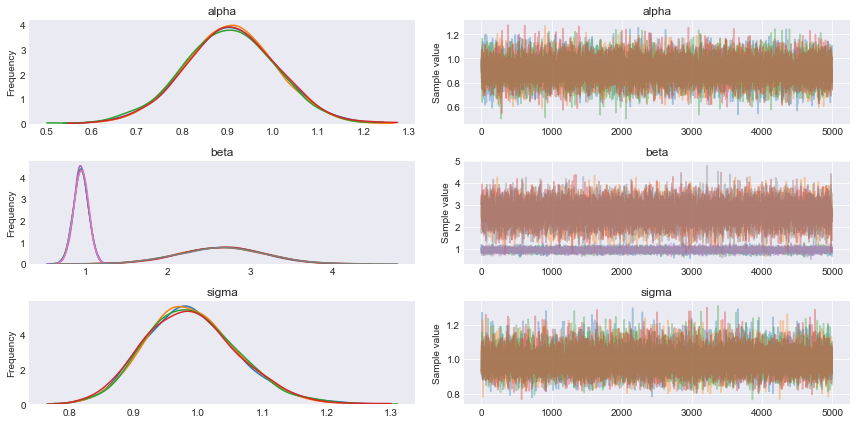

In [14]:
pm.traceplot(trace2)

In addition, the summary function provides a text-based output of common posterior statistics:

In [15]:
pm.summary(trace2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,0.906435,0.100369,0.000761,0.701441,1.098265,19062.334199,1.000437
beta__0,0.948609,0.087745,0.000615,0.772363,1.117679,19715.092430,1.000112
beta__1,2.645994,0.506909,0.004076,1.637331,3.618268,15694.926661,1.000276
sigma,0.990456,0.071611,0.000525,0.857706,1.134210,17515.544005,0.999963


In [22]:
trace2["alpha"]

array([0.90542641, 0.98356822, 0.88550758, ..., 0.85496201, 0.89226615,
       0.74222812])

In [24]:
trace2["sigma"]

array([1.04328132, 1.0359946 , 0.92784412, ..., 1.07857943, 0.9261119 ,
       1.01079641])

In [25]:
trace2["beta"] #beta_0 and beta_1 does not exist

array([[0.82714797, 3.4149382 ],
       [1.19107337, 2.34761152],
       [0.87498519, 2.29630148],
       ...,
       [0.96759943, 2.68160425],
       [0.9844434 , 2.47393946],
       [1.08003443, 2.68677461]])

In [27]:
trace2.alpha.shape #5000*4 (4 threads/chains, each with 5000 sampling)

(20000,)

The 4 colored curves of each variable probably stand for the 4-thread separate samplings; in the summary table, all results from the 4 different samplings are merged together

#a better way to visualize the results is to use arviz
git clone https://github.com/arviz-devs/arviz.git
cd arviz
python setup.py build
python setup.py install

#also install the dependencies
conda install netCDF4 
conda install xarray

#however, it is giving more errors; so I am not going to try to use arviz; the default plotting from pymc3 is good enough